# Stat-xplore statistics for Lewisham

Fetches labour market data

_This requires the `OA->LSOA` lookup table produced by `lbl_boundaries_oa.ipynb` as well as the `OA->WD22` lookup table produced by "`lbl_boundaries_2022_wards.ipynb`"_

# Setup

## Imports

In [1]:
%%capture
!pip install https://github.com/philipbrien/statxplorer/zipball/master
!pip install geopandas

In [2]:
import statxplorer
key = "65794a30655841694f694a4b563151694c434a68624763694f694a49557a49314e694a392e65794a7063334d694f694a7a644849756333526c6247786863694973496e4e3159694936496d6c7563326c6e614851745957356b4c57526c62476c325a584a355147786c64326c7a614746744c6d64766469353161794973496d6c68644349364d54597a4e7a497a4d6a51344d5377695958566b496a6f69633352794c6d396b59534a392e764b6a5355767a594132314a374a6a5f31345076774f6243584a6178576a52303173634e68547238517863"
import json
explorer = statxplorer.StatXplorer(key)


In [5]:
import os

import pandas as pd
import geopandas as gpd
import IPython
import matplotlib
import matplotlib.pyplot as plt

## Filesystem

In [6]:
# Determine if in google colab
def in_colab():
    return True if os.getenv("HOME") == "/root" else False

In [7]:
# Google Drive access
if in_colab():
    from google.colab import drive
    drive.mount("/content/gdrive")
    project_dir = "/content/gdrive/MyDrive/WardProfiles"
else:
    project_dir = "/Volumes/GoogleDrive/My Drive/WardProfiles"

print("project_dir:", project_dir)


Mounted at /content/gdrive
project_dir: /content/gdrive/MyDrive/WardProfiles


In [8]:
oa_lookups_dir = f"{project_dir}/lookups/oa"
ward_lookups_dir = f"{project_dir}/lookups/2022_wards"
oa_dir = f"{project_dir}/boundaries/oa"
ward_dir = f"{project_dir}/boundaries/2022_wards"

# For exports
output_dir = f"{project_dir}/disability_living_allowance"

In [ ]:
!mkdir -p '{output_dir}'

In [ ]:
!ls '{output_dir}'

table_2021-12-07_21-40-19.json


Downloads
--

[Dataset: Disability Living Allowance (DLA)](https://stat-xplore.dwp.gov.uk/webapi/metadata/DLA_Entitled_New/DLA_Entitled_New.html)

```
 Dataset: Disability Living Allowance (All Entitled cases)

Description

Disability Living Allowance (DLA) is a tax-free benefit for disabled people who need help with mobility or care costs. It replaced and extended Attendance Allowance (AA) and Mobility Allowance (MobA) for people in this age group from April 1992.

You can claim for DLA if you are under 16 or if you were born after 8 April 1948 and you make a claim in the same year you stopped receiving DLA. From 8 April 2013, Disability Living Allowance for people of working age was replaced by Personal Independence payment (PIP) for new claims. PIP is also gradually replacing existing DLA claims for people of working age.

DLA has two components which can be paid together or on their own:

A care component for people who have needed help with personal care for at least 3 months and are likely to go on needing that help for at least a further 6 months.

A mobility component for people who have had walking difficulties for at least 3 months and are likely to continue to have those difficulties for at least a further 6 months.

The statistics available here include those who have had their payment suspended, for example if they are in hospital.

Recording and clerical errors can occur within the data source - for this reason, no reliance should be placed on very small numbers obtained through Stat-Xplore.

Statistical disclosure control has been applied with Stat-Xplore, which guards against the identification of an individual claimant.

```

In [9]:
def get_data(statxplore_table_config):
    query = f'{output_dir}/{statxplore_table_config}.json'
    results = explorer.fetch_table(query, reshape=False)
    data = results['data']
    return data

In [10]:
# get the data from the statxplore api - this is based on a pre-existing file that sets the parameters to be used
# https://stat-xplore.dwp.gov.uk/webapi/jsf/tableView/tableView.xhtml
df = get_data(statxplore_table_config='table_2021-12-07_21-40-19')

In [11]:
df.head()

,National - Regional - LA - OAs,Quarter,DLA (entitled) - 2011 Geographies
0,England,May-21,1115925.0
1,London,May-21,157049.0
2,Lewisham,May-21,5962.0
3,E00016326,May-21,6.0
4,E00016329,May-21,6.0


## Functions to transform data

In [12]:
# epoch - list of matching time values (e.g. 'August 2021')
# lbl_oa_list - filter list of matching labels (e.g. England, London...)
def filter_statxplore_data(d, date_values, geography_values):  
  # use the `Quarter` and `National - Regional  - LA - OAs`
  return d[d['Quarter'].isin(date_values) &
           d['National - Regional - LA - OAs'].isin(geography_values)]

In [13]:
def format_statxplore_data(d, geo_colname):
  return d.\
           rename(columns={'National - Regional - LA - OAs': geo_colname})

In [14]:
# Convenience function to call the above two
def statxplore_to_oa(d, years, oa_list):
  return format_statxplore_data(filter_statxplore_data(d, years, oa_list),'OA11CD')

In [15]:
# Aggregate OA-level data to LSOAs, Wards, etc. (Calculates the sum.)
def aggregate_oa_groups(oa_data, greater_group_table, oa_col, greater_col, group_col):
  return pd.merge(oa_data, greater_group_table, left_on=[oa_col], right_on=[greater_col], how='right').\
              drop(columns=[oa_col]).\
              groupby(group_col).sum()


Lookups
--
Used to match up OAs with their LSOAs, and 2022 electoral wards

In [16]:
# All OAs and their LSOAs in Lewisham
oa_lsoa_join = pd.read_csv(f"{oa_lookups_dir}/lbl_oa11_lsoa11_msoa11_lad20_rgn20_202012.csv")
oa_lsoa_join = oa_lsoa_join[['OA11CD', 'LSOA11CD']]
oa_lsoa_join.head()

,OA11CD,LSOA11CD
0,E00016277,E01003220
1,E00016278,E01003220
2,E00016285,E01003220
3,E00016257,E01003221
4,E00016263,E01003221


In [17]:
# All OAs and their 2022 wards in Lewisham
oa_wd22_join = pd.read_csv(f"{ward_lookups_dir}/lbl_oa11_wd22_proposed.csv")
oa_wd22_join = oa_wd22_join[['OA11CD', 'WD22CD_proposed']]
oa_wd22_join.head()

,OA11CD,WD22CD_proposed
0,E00016403,E05013721
1,E00016442,E05013721
2,E00016407,E05013721
3,E00016404,E05013721
4,E00016402,E05013721


Process & export
==

Absolute numbers
--

In [18]:
epoch = ['May-21']
lbl_oa_list = oa_lsoa_join.OA11CD.unique()

for datname in ['disability_living_allowance']:
  IPython.display.display(f"=== {datname} ===")

  # Simplify the column names
  df.columns = df.columns.str.replace(
      # Remove the redundant qualifier suffix
      r'^(.*?) - 2011 Geographies', 
      r'\1')

  # First process the Lewisham subset
  oas = filter_statxplore_data(df,epoch,lbl_oa_list)
  # d = statxplore_to_oa(oas, epoch,lbl_oa_list)

  # Transform to OA index data
  lbl_oa = statxplore_to_oa(oas, epoch, lbl_oa_list)
  lbl_oa.to_csv(f"{output_dir}/lbl_{datname}_oa11.csv", index=False)
  IPython.display.display(lbl_oa.head())

  # Aggregate to LSOA level
  lbl_lsoa = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_lsoa_join, oa_col="OA11CD", greater_col='OA11CD', group_col='LSOA11CD')
  lbl_lsoa.to_csv(f"{output_dir}/lbl_{datname}_lsoa11.csv", index=True)
  IPython.display.display(lbl_lsoa.head())

  # Aggregate to WD22 level  
  lbl_wd22 = aggregate_oa_groups(oa_data=lbl_oa, greater_group_table=oa_wd22_join, oa_col="OA11CD", greater_col='OA11CD', group_col='WD22CD_proposed')
  lbl_wd22.to_csv(f"{output_dir}/lbl_{datname}_wd22.csv", index=True)
  IPython.display.display(lbl_wd22.head())

  # Aggregate to London level  
  refs = filter_statxplore_data(df,epoch,['Lewisham','London','England'])
  refs = refs.rename(columns={'National - Regional - LA - OAs': 'Name'})
  refs.to_csv(f"{output_dir}/references_{datname}.csv", index=False)
  IPython.display.display(refs.head())



'=== disability_living_allowance ==='

,OA11CD,Quarter,DLA (entitled)
3,E00016326,May-21,6.0
4,E00016329,May-21,6.0
5,E00016332,May-21,6.0
6,E00016333,May-21,0.0
7,E00016337,May-21,5.0


,DLA (entitled)
LSOA11CD,
E01003189,65.0
E01003190,52.0
E01003191,48.0
E01003192,49.0
E01003193,56.0


,DLA (entitled)
WD22CD_proposed,
E05013714,363.0
E05013715,228.0
E05013716,243.0
E05013717,389.0
E05013718,263.0


,Name,Quarter,DLA (entitled)
0,England,May-21,1115925.0
1,London,May-21,157049.0
2,Lewisham,May-21,5962.0


Relative numbers
--

In [ ]:
# TODO: we need to get a population total to compute this
# Need to review StatXplore methodology to see what their population sample basis is

## Spatial

In [ ]:
# Ward22 geometry
wd22 = gpd.read_file(f"{ward_dir}/lbl_wd22_proposed.gpkg")
len(wd22)

19

In [ ]:
# OA geometry
oa11 = gpd.read_file(f"{oa_dir}/lbl_oa11_20m.gpkg")
len(oa11)

887

In [ ]:
education_oa_geom = oa11.merge(lbl_oa, left_on='OA11CD', right_on='OA11CD')

# Output

No handles with labels found to put in legend.


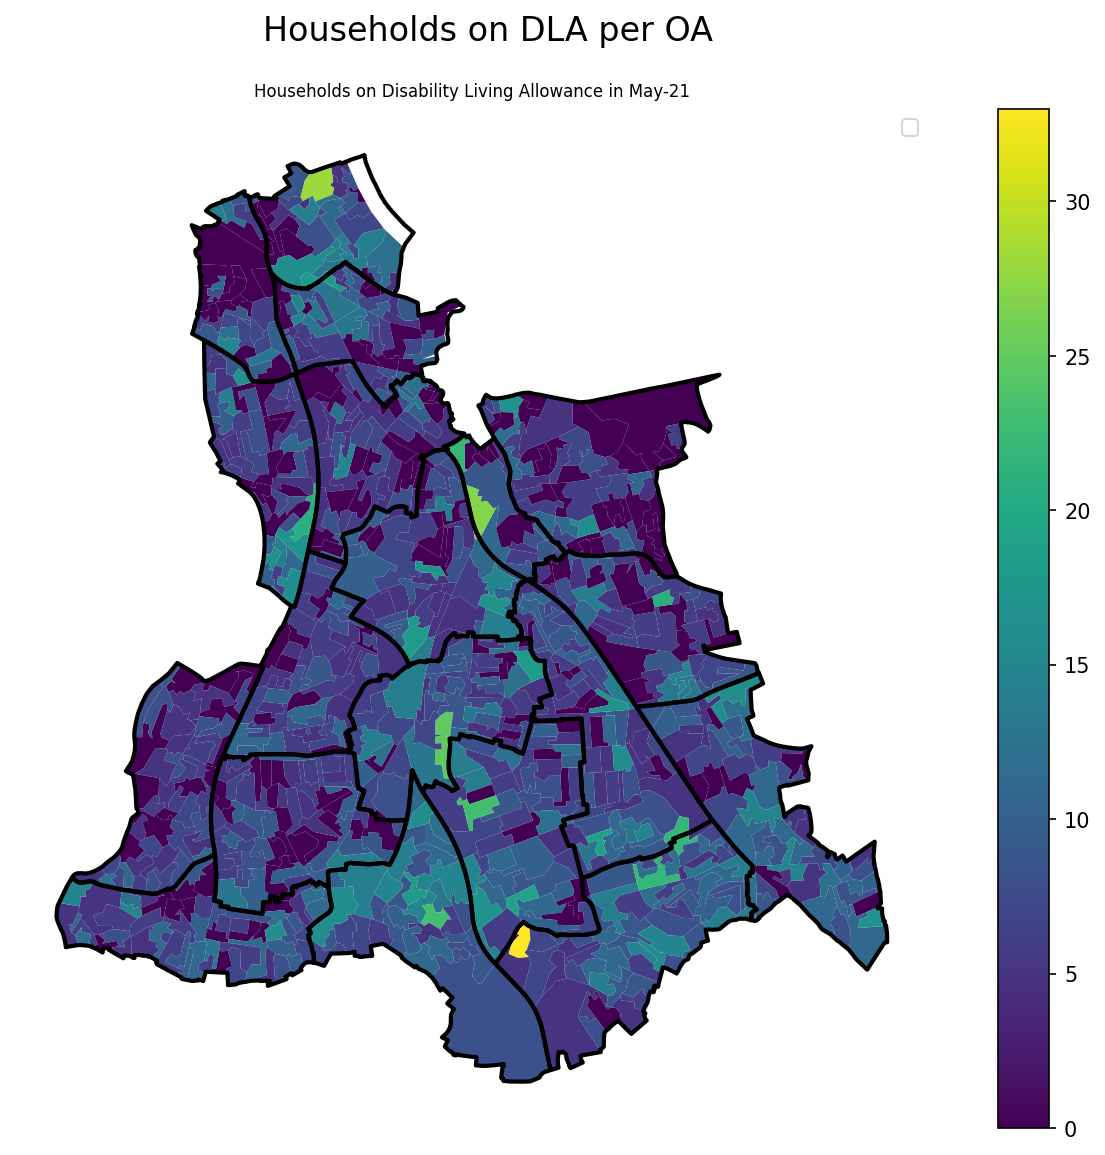

In [ ]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 9), dpi=150)
plt.suptitle('Households on DLA per OA', fontsize=16, y=.95)
plt.title('Households on Disability Living Allowance in '+epoch[0], fontsize=8)
education_oa_geom.plot(ax=ax, column="DLA (entitled)", legend=True)
plt.legend()
wd22.plot(ax=ax, facecolor='none', linewidth=2, edgecolor='black')

plt.axis('off')

plt.savefig(f"{output_dir}/lbl_oa11_jsa.png", dpi=600)
plt.savefig(f"{output_dir}/lbl_oa11_jsa.pdf")